# **Oversampling**

## **Import library & load data**

*   Menggunakan pymysql + SQLAlchemy untuk membaca dataset dari tabel ecoli_dataset yang terhubung di database cloud menggunakan aiven.

*   Data disimpan ke pandas DataFrame.

In [40]:
!pip install pymysql
!pip install pandas
!pip install sqlalchemy
!pip install python-dotenv
!pip install imbalanced-learn


In [41]:
from google.colab import files
uploaded = files.upload()

Saving UCI.env to UCI.env


In [42]:
import pandas as pd
from sqlalchemy import create_engine
import os
from dotenv import load_dotenv
import io

# Load the content of the uploaded .env file
env_content = uploaded['UCI.env'].decode('utf-8')

# Parse the content and set environment variables manually, removing angle brackets
for line in env_content.splitlines():
    if '=' in line:
        key, value = line.split('=', 1)
        os.environ[key.strip()] = value.strip().replace('<', '').replace('>', '')

# Ambil variabel koneksi dari lingkungan
MYSQL_HOST = os.getenv("MYSQL_HOST")
MYSQL_PORT = os.getenv("MYSQL_PORT")
MYSQL_USER = os.getenv("MYSQL_USER")
MYSQL_PASSWORD = os.getenv("MYSQL_PASSWORD")
MYSQL_DATABASE = os.getenv("MYSQL_DATABASE")

# Gunakan SQLAlchemy untuk koneksi ke MySQL
# Ensure the port is an integer
mysql_engine = create_engine(f"mysql+pymysql://{MYSQL_USER}:{MYSQL_PASSWORD}@{MYSQL_HOST}:{int(MYSQL_PORT)}/{MYSQL_DATABASE}")

# Jalankan query
mysql_query = "SELECT * FROM ecoli_dataset;"
df = pd.read_sql(mysql_query, mysql_engine)

# Print hasil
print("Data dari MySQL:")
print(df.head())

Data dari MySQL:
     sequence   mcg   gvh   lip  chg   aac  alm1  alm2 class
0   AAS_ECOLI  0.44  0.52  0.48  0.5  0.43  0.47  0.54    im
1   AAT_ECOLI  0.49  0.29  0.48  0.5  0.56  0.24  0.35    cp
2  ACEA_ECOLI  0.07  0.40  0.48  0.5  0.54  0.35  0.44    cp
3  ACEK_ECOLI  0.56  0.40  0.48  0.5  0.49  0.37  0.46    cp
4  ACKA_ECOLI  0.59  0.49  0.48  0.5  0.52  0.45  0.36    cp


## **Preprocessing Data**

Dari dataset, kolom non-numerik seperti class (label target) dan sequence dihapus dari variabel fitur X. Label kelas class disimpan di y. Selanjutnya, semua fitur numerik pada X distandarisasi dengan MinMaxScaler agar berada pada skala yang sama.

In [48]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Buang kolom non-numerik
X = df.drop(["class", "sequence"], axis=1)
y = df["class"]

# Normalisasi fitur numerik ke rentang [0,1]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

## **Data Original**

Principal Component Analysis (PCA) digunakan untuk mereduksi dimensi data menjadi 2 komponen utama (PC1 dan PC2). Hasil reduksi divisualisasikan dalam bentuk scatter plot, sehingga distribusi data antar kelas dapat diamati sebelum dilakukan penyeimbangan kelas.

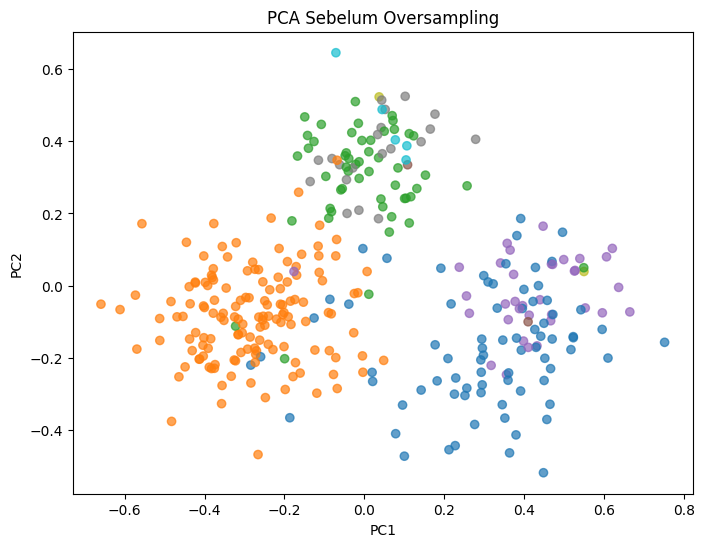

In [49]:
# PCA 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot sebelum oversampling
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pd.factorize(y)[0], cmap="tab10", alpha=0.7)
plt.title("PCA Sebelum Oversampling")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


## **Oversampling dengan SMOTE**

Teknik SMOTE diterapkan untuk menambah jumlah data pada kelas minoritas dengan cara membuat sampel sintetis baru. Karena terdapat kelas yang hanya memiliki sedikit sampel, parameter k_neighbors diset menjadi 1 agar proses tidak gagal. Distribusi kelas setelah oversampling ditampilkan untuk membandingkan dengan kondisi awal.

In [50]:
from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter

print("Distribusi awal:", Counter(y))

# SMOTE
smote = SMOTE(random_state=42, k_neighbors=1)
X_smote, y_smote = smote.fit_resample(X_scaled, y)
print("Distribusi setelah SMOTE:", Counter(y_smote))

Distribusi awal: Counter({'cp': 143, 'im': 77, 'pp': 52, 'imU': 35, 'om': 20, 'omL': 5, 'imS': 2, 'imL': 2})
Distribusi setelah SMOTE: Counter({'im': 143, 'cp': 143, 'pp': 143, 'imU': 143, 'imS': 143, 'om': 143, 'imL': 143, 'omL': 143})


## **Oversampling dengan ADASYN**

Selain SMOTE, teknik ADASYN juga dicoba untuk menyeimbangkan kelas. ADASYN bekerja dengan memberikan bobot lebih pada kelas yang sulit dipelajari, sehingga lebih adaptif. Namun, karena dataset ini memiliki kelas yang sangat sedikit, proses ADASYN bisa gagal. Oleh karena itu, dilakukan iterasi dengan penyesuaian nilai n_neighbors agar dapat berjalan. Jika berhasil, distribusi kelas baru ditampilkan.

In [51]:
print("Distribusi kelas sebelum ADASYN:")
print(f"{sorted(Counter(y).items())}")

nt = X_scaled
ns = y

class_counts = Counter(y).values()
temp = sorted(class_counts)
print(f"Sorted counts untuk iterasi: {temp}")

for i in range(0, 7):
    n = max(1, temp[i] - 1)

    print(f"\nIterasi {i+1}: menggunakan k_neighbors={n}")

    try:
        nt, ns = ADASYN(n_neighbors=n, sampling_strategy='minority').fit_resample(nt, ns)
        print(f"Hasil iterasi {i+1}: {sorted(Counter(ns).items())}")
    except Exception as e:
        print(f"Error pada iterasi {i+1}: {e}")
        break

print(f"\nDistribusi kelas setelah ADASYN:")
print(f"{sorted(Counter(ns).items())}")

print(f"\nTotal samples sebelum: {len(y)}")
print(f"Total samples setelah: {len(ns)}")
print(f"Data yang ditambahkan: {len(ns) - len(y)}")

Distribusi kelas sebelum ADASYN:
[('cp', 143), ('im', 77), ('imL', 2), ('imS', 2), ('imU', 35), ('om', 20), ('omL', 5), ('pp', 52)]
Sorted counts untuk iterasi: [2, 2, 5, 20, 35, 52, 77, 143]

Iterasi 1: menggunakan k_neighbors=1
Hasil iterasi 1: [('cp', 143), ('im', 77), ('imL', 142), ('imS', 2), ('imU', 35), ('om', 20), ('omL', 5), ('pp', 52)]

Iterasi 2: menggunakan k_neighbors=1
Hasil iterasi 2: [('cp', 143), ('im', 77), ('imL', 142), ('imS', 142), ('imU', 35), ('om', 20), ('omL', 5), ('pp', 52)]

Iterasi 3: menggunakan k_neighbors=4
Error pada iterasi 3: Not any neigbours belong to the majority class. This case will induce a NaN case with a division by zero. ADASYN is not suited for this specific dataset. Use SMOTE instead.

Distribusi kelas setelah ADASYN:
[('cp', 143), ('im', 77), ('imL', 142), ('imS', 142), ('imU', 35), ('om', 20), ('omL', 5), ('pp', 52)]

Total samples sebelum: 336
Total samples setelah: 616
Data yang ditambahkan: 280


## **Reduksi Dimensi dengan PCA setelah oversampling**

Setelah oversampling (baik SMOTE maupun ADASYN), data kembali direduksi ke dalam 2 dimensi dengan PCA. Scatter plot ditampilkan untuk memperlihatkan distribusi data baru setelah penambahan data sintetis. Visualisasi ini mempermudah perbandingan kondisi sebelum dan sesudah oversampling.

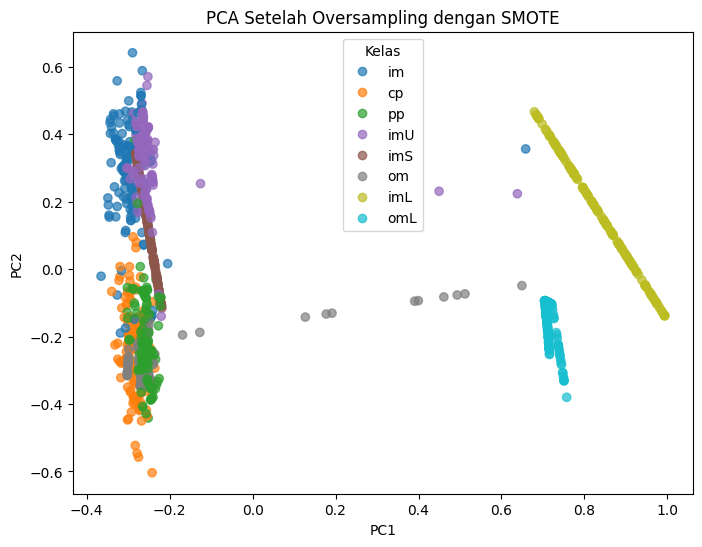

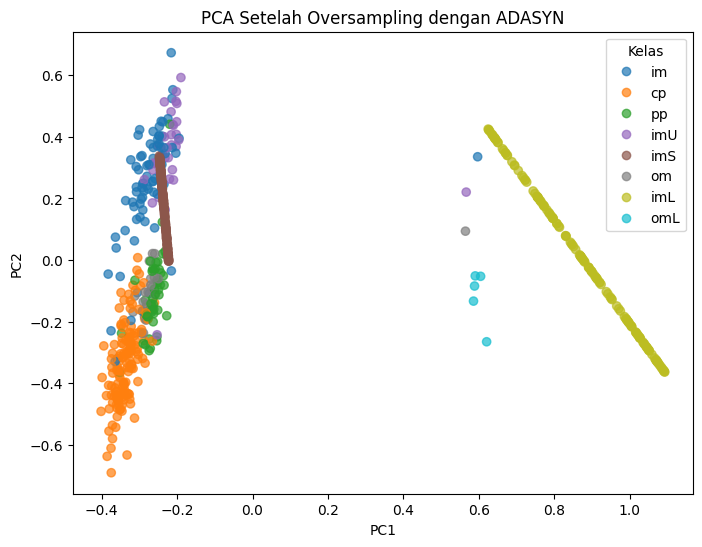

In [52]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

# ========================
# PCA & Scatter Plot setelah SMOTE
# ========================
pca = PCA(n_components=2)
X_smote_pca = pca.fit_transform(X_smote)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_smote_pca[:, 0], X_smote_pca[:, 1],
                      c=pd.factorize(y_smote)[0], cmap="tab10", alpha=0.7)

# Tambahkan legend sesuai kelas
handles, labels = scatter.legend_elements()
class_labels = pd.Series(y_smote).unique()  # ambil nama kelas unik
plt.legend(handles, class_labels, title="Kelas")

plt.title("PCA Setelah Oversampling dengan SMOTE")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# ========================
# PCA & Scatter Plot setelah ADASYN (jika berhasil)
# ========================
if len(ns) > len(y):  # cek apakah ADASYN berhasil menambah data
    pca = PCA(n_components=2)
    X_adasyn_pca = pca.fit_transform(nt)

    plt.figure(figsize=(8,6))
    scatter = plt.scatter(X_adasyn_pca[:, 0], X_adasyn_pca[:, 1],
                          c=pd.factorize(ns)[0], cmap="tab10", alpha=0.7)

    # Tambahkan legend sesuai kelas
    handles, labels = scatter.legend_elements()
    class_labels = pd.Series(ns).unique()
    plt.legend(handles, class_labels, title="Kelas")

    plt.title("PCA Setelah Oversampling dengan ADASYN")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()
else:
    print("⚠️ ADASYN tidak berhasil menambah data, visualisasi dilewati.")
